In [42]:
import numpy as np
import json
import pandas as pd
import random
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from scipy import stats
import seaborn as sns
from fastapi import FastAPI
import uvicorn
from pydantic import BaseModel
from enum import Enum
import threading
import subprocess
import time
import requests
import plotly.express as px
import plotly.graph_objects as go
from fastapi.responses import HTMLResponse
import base64
from io import BytesIO
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('appointment_reminder_dataset.csv')

In [3]:
df.head()

,patient_id,appointment_id,age,gender,digital_literacy,employment_status,has_chronic_condition,distance_from_clinic_km,preferred_contact_method,past_appointments_count,...,cancelled_in_advance,cancellation_hours_advance,rescheduled,arrived_late,minutes_late,no_show,day_name,is_weekend,is_morning_appointment,age_group
0,1,APT0000100,54,F,Medium,Full-time,0,2.0,SMS,4,...,0,0.00000,0,0,NaN,1,Monday,0,0,46-60
1,2,APT0000200,65,M,High,Retired,1,24.0,SMS,3,...,0,NaN,0,0,0.0,0,Tuesday,0,0,60+
2,2,APT0000201,65,M,High,Retired,1,24.0,SMS,3,...,0,NaN,0,0,0.0,0,Wednesday,0,0,60+
3,3,APT0000300,28,F,High,Full-time,0,7.4,Email,8,...,1,39.62129,1,0,NaN,1,Friday,0,0,18-30
4,4,APT0000400,27,F,Medium,Full-time,1,7.1,SMS,6,...,0,NaN,0,0,0.0,0,Tuesday,0,1,18-30


In [4]:
df.shape

(15070, 39)

In [5]:
df.duplicated().sum()

np.int64(0)

In [6]:
df.isnull().sum()

,0
patient_id,0
appointment_id,0
age,0
gender,0
digital_literacy,0
employment_status,0
has_chronic_condition,0
distance_from_clinic_km,0
preferred_contact_method,0
past_appointments_count,0


In [7]:
df.drop_duplicates()

,patient_id,appointment_id,age,gender,digital_literacy,employment_status,has_chronic_condition,distance_from_clinic_km,preferred_contact_method,past_appointments_count,...,cancelled_in_advance,cancellation_hours_advance,rescheduled,arrived_late,minutes_late,no_show,day_name,is_weekend,is_morning_appointment,age_group
0,1,APT0000100,54,F,Medium,Full-time,0,2.0,SMS,4,...,0,0.00000,0,0,NaN,1,Monday,0,0,46-60
1,2,APT0000200,65,M,High,Retired,1,24.0,SMS,3,...,0,NaN,0,0,0.0,0,Tuesday,0,0,60+
2,2,APT0000201,65,M,High,Retired,1,24.0,SMS,3,...,0,NaN,0,0,0.0,0,Wednesday,0,0,60+
3,3,APT0000300,28,F,High,Full-time,0,7.4,Email,8,...,1,39.62129,1,0,NaN,1,Friday,0,0,18-30
4,4,APT0000400,27,F,Medium,Full-time,1,7.1,SMS,6,...,0,NaN,0,0,0.0,0,Tuesday,0,1,18-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15065,9996,APT0999601,47,M,Low,Full-time,0,10.1,SMS,3,...,0,NaN,0,0,0.0,0,Tuesday,0,0,46-60
15066,9997,APT0999700,28,F,High,Full-time,0,4.7,App,5,...,0,NaN,0,0,0.0,0,Tuesday,0,0,18-30
15067,9998,APT0999800,42,F,Low,Full-time,0,2.2,Email,6,...,0,NaN,0,0,0.0,0,Wednesday,0,0,31-45
15068,9999,APT0999900,25,M,High,Part-time,1,1.7,Email,5,...,0,NaN,0,0,0.0,0,Thursday,0,0,18-30


In [8]:
df.shape


(15070, 39)

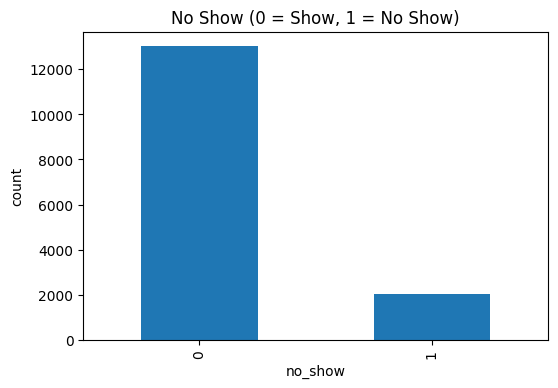

In [9]:
plt.figure(figsize = (6,4))
df['no_show'].value_counts().plot(kind ='bar')
plt.title('No Show (0 = Show, 1 = No Show)')
plt.ylabel('count')
plt.show()

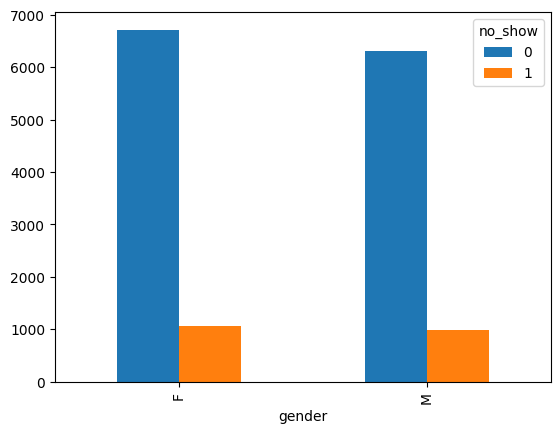

In [10]:
gender_noshow = pd.crosstab(df['gender'], df['no_show'])
gender_noshow.plot(kind='bar')
plt.show()
# both male and female show and no- show are almost equal


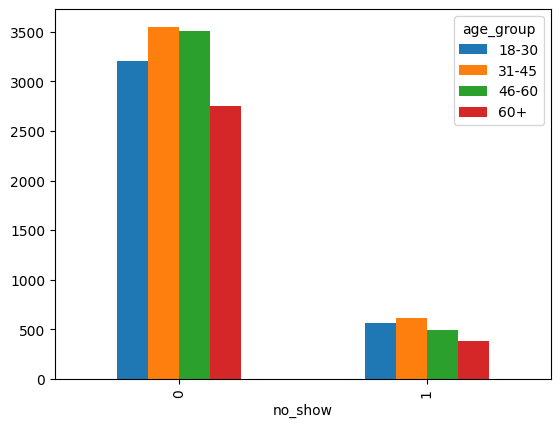

In [11]:
age_noshow = pd.crosstab(df['no_show'],df['age_group'])
age_noshow.plot(kind = 'bar')
plt.show()

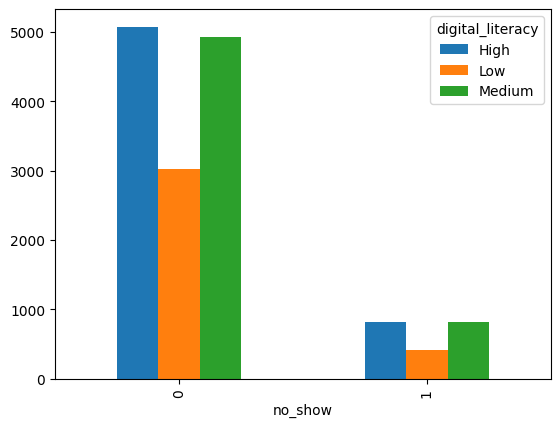

In [12]:
digital_literacy_no_show = pd.crosstab(df['no_show'],df['digital_literacy'])
digital_literacy_no_show.plot(kind ='bar')
plt.show()
#people with high digital literacy showed up more

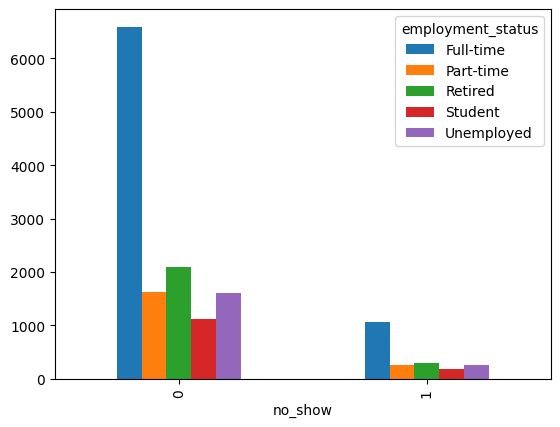

In [13]:
employment_status_no_show = pd.crosstab(df['no_show'],df['employment_status'])
employment_status_no_show.plot(kind ='bar')
plt.show()

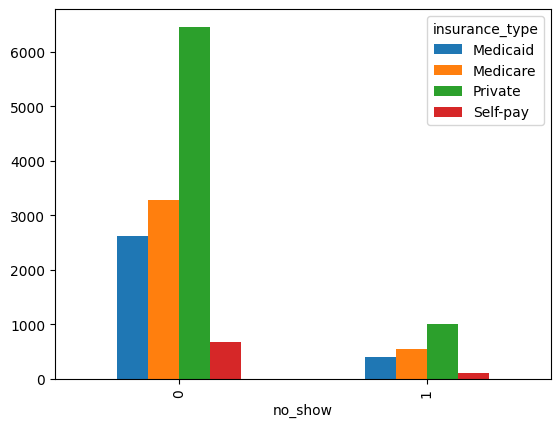

In [14]:
insurance_no_show = pd.crosstab(df['no_show'],df['insurance_type'])
insurance_no_show.plot(kind ='bar')
plt.show()

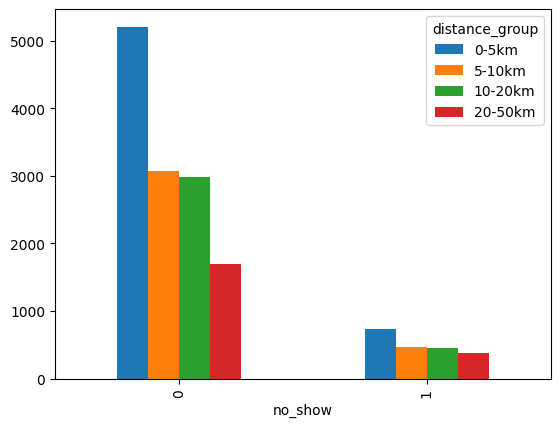

In [15]:

distance_bins = [0, 5, 10, 20, 50, 100]  # km
distance_labels = ['0-5km', '5-10km', '10-20km', '20-50km', '50+km']

df['distance_group'] = pd.cut(df['distance_from_clinic_km'],
                             bins=distance_bins,
                             labels=distance_labels)
distance_analysis = pd.crosstab(df['no_show'], df['distance_group'])
distance_analysis.plot(kind='bar')
plt.show()

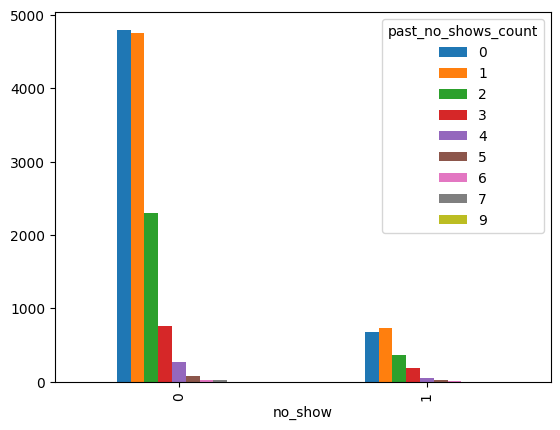

In [16]:
past_no_show_counts_analysis = pd.crosstab(df['no_show'],df['past_no_shows_count'])
past_no_show_counts_analysis.plot(kind='bar')
plt.show()

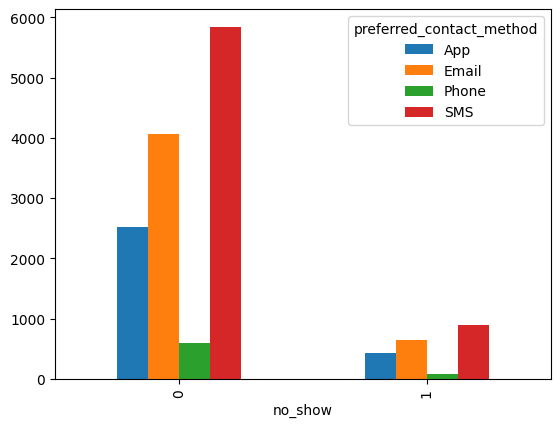

In [17]:
contact_analysis = pd.crosstab(df['no_show'], df['preferred_contact_method'])
contact_analysis.plot(kind='bar')
plt.show()

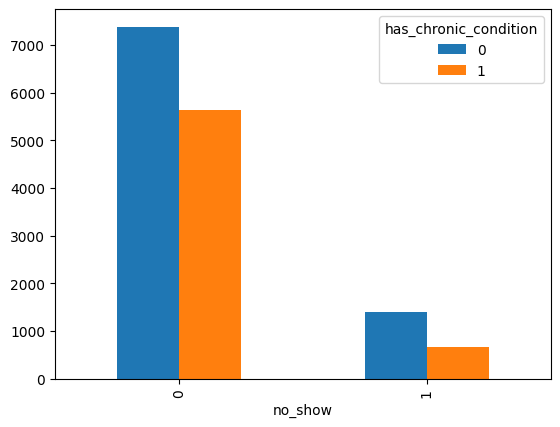

In [18]:
chronic_analysis = pd.crosstab(df['no_show'], df['has_chronic_condition'])
chronic_analysis.plot(kind='bar')
plt.show()

In [19]:
#Feature Engineering

digital_map = {'High': 2,'Medium': 1,'Low': 0}
df['digital_literacy'] = df['digital_literacy'].map(digital_map)

df['distance_group'] = pd.cut(df['distance_from_clinic_km'],
                             bins=[0,5,10,30,100],
                             labels=['0-5km','5-10km','10-30km','30+km'])

df['past_no_shows_count'] = (df['past_no_shows_count']/(df['past_appointments_count'] + 1))

df['is_repeat_offender'] = (df['past_no_shows_count']> 0).astype(int)

#one-hot encoding
employment_dummies = pd.get_dummies(df['employment_status'], prefix='emp')
contact_dummies = pd.get_dummies(df['preferred_contact_method'], prefix='contact')


In [20]:
df = pd.concat([df,employment_dummies,contact_dummies],axis = 1)
print(f"total features : {df.shape[1]}")
print(df.columns.tolist())

total features : 50
['patient_id', 'appointment_id', 'age', 'gender', 'digital_literacy', 'employment_status', 'has_chronic_condition', 'distance_from_clinic_km', 'preferred_contact_method', 'past_appointments_count', 'past_no_shows_count', 'historical_no_show_rate', 'appointment_specialty', 'appointment_type', 'day_of_week', 'appointment_hour', 'booking_lead_days', 'previous_cancellations', 'insurance_type', 'on_waitlist', 'season', 'weather_forecast', 'test_group', 'reminder_type', 'reminder_timing_hours_before', 'number_of_reminders_sent', 'reminder_opened', 'reminder_acknowledged', 'showed_up', 'cancelled_in_advance', 'cancellation_hours_advance', 'rescheduled', 'arrived_late', 'minutes_late', 'no_show', 'day_name', 'is_weekend', 'is_morning_appointment', 'age_group', 'distance_group', 'is_repeat_offender', 'emp_Full-time', 'emp_Part-time', 'emp_Retired', 'emp_Student', 'emp_Unemployed', 'contact_App', 'contact_Email', 'contact_Phone', 'contact_SMS']


In [21]:
# Check new employment columns
print("Employment columns:")
print([col for col in df.columns if 'emp_' in col])

# Check new contact columns
print("\nContact columns:")
print([col for col in df.columns if 'contact_' in col])

# Check your engineered features
print("\nYour engineered features:")
print(['digital_literacy', 'distance_group', 'past_no_show_rate', 'is_repeat_offender'])

Employment columns:
['emp_Full-time', 'emp_Part-time', 'emp_Retired', 'emp_Student', 'emp_Unemployed']

Contact columns:
['preferred_contact_method', 'contact_App', 'contact_Email', 'contact_Phone', 'contact_SMS']

Your engineered features:
['digital_literacy', 'distance_group', 'past_no_show_rate', 'is_repeat_offender']


In [22]:
le = LabelEncoder()
categorical_columns = df.select_dtypes(include=['object', 'category']).columns
for col in categorical_columns:
  df[col] = le.fit_transform(df[col].astype(str))

In [23]:
X = df.drop('no_show',axis = 1)
y = df['no_show']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

In [24]:
model = xgb.XGBClassifier(random_state = 42, enable_categorical=True)
model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [25]:
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Accuracy: 1.0000


In [26]:
print(f"training samples:{len(X_train)}")
print(f"test samples:{len(X_test)}")
print("\nClassification Report:")
print(classification_report(y_test,y_pred))
print("\nClassification Matrix:")
print(classification_report(y_test,y_pred))
print(f"\nUnique classes in y_test:{np.unique(y_test)}")
print(f"Class distribution in y_test:{np.bincount(y_test)}")


training samples:12056
test samples:3014

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2619
           1       1.00      1.00      1.00       395

    accuracy                           1.00      3014
   macro avg       1.00      1.00      1.00      3014
weighted avg       1.00      1.00      1.00      3014


Classification Matrix:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2619
           1       1.00      1.00      1.00       395

    accuracy                           1.00      3014
   macro avg       1.00      1.00      1.00      3014
weighted avg       1.00      1.00      1.00      3014


Unique classes in y_test:[0 1]
Class distribution in y_test:[2619  395]


In [27]:
def create_reminder_strategy_dataset(df,n_patients = 5000):
  """
  Create a stimulated dataset for reminder strategy A/B testing
  """
  np.random.seed(42)

  strategies = ['SMS_24h','SMS_48h','Email_24h','Phone_24h','App_24h','Multi-Channel']

  test_data = []

  for i in range (n_patients):
    strategy = random.choice(strategies)
    patient_profile = df.sample(1).iloc[0]
    base_no_show_prob = 0.15

    if patient_profile['digital_literacy'] == 0:
      base_no_show_prob += 0.05
    elif patient_profile['digital_literacy'] == 2:
      base_no_show_prob += 0.03

    if patient_profile['past_no_shows_count'] > 0:
      base_no_show_prob += 0.08

    if patient_profile['distance_from_clinic_km'] > 20:
      base_no_show_prob += 0.04

    if patient_profile['age'] > 60:
      base_no_show_prob += 0.02

    strategy_effectiveness = {
        'SMS_24h': 0.80,
        'SMS_48h': 0.85,
        'Email_24h': 0.75,
        'Phone_24h': 0.70,
        'App_24h': 0.78,
        'Multi-Channel': 0.65
    }
    final_no_show_prob = base_no_show_prob * strategy_effectiveness[strategy]
    final_no_show_prob = max(0.02,min(0.98,final_no_show_prob))

    no_show = np.random.binomial(1,final_no_show_prob)
    test_data.append({'patient_id':f"TEST_{i+1:05d}",
                      'strategy':strategy,
                      'age':patient_profile['age'],
                      'gender':patient_profile['gender'],
                      'distance_from_clinic':patient_profile['distance_from_clinic_km'],
                      'digital_literacy':patient_profile['digital_literacy'],
                      'employment_status':patient_profile['employment_status'],
                      'has_chronic_condition':patient_profile['has_chronic_condition'],
                      'base_no_show_prob':base_no_show_prob,
                      'final_no_show_prob':final_no_show_prob,
                      'no_show':no_show,
                      'past_no_shows_count':patient_profile['past_no_shows_count'],
                      'attended':1-no_show})
  return pd.DataFrame(test_data)

print("Creating A/B test dataset...")
ab_test_df = create_reminder_strategy_dataset(df, n_patients=3000)
print(f"Created dataset with {len(ab_test_df)} simulated appointments")
print(f"Strategies: {ab_test_df['strategy'].unique()}")

Creating A/B test dataset...
Created dataset with 3000 simulated appointments
Strategies: ['Multi-Channel' 'Phone_24h' 'Email_24h' 'SMS_48h' 'App_24h' 'SMS_24h']


In [28]:
def analyze_ab_test_results(ab_test_df):
  """Comprehensive analysis of the A/B test"""
  print("="*60)
  print("A/B Test Results Analysis: Reminder Strategies")
  print("="*60)

  strategy_results = ab_test_df.groupby('strategy').agg({
      'no_show':['count','mean','std'],
      'attended':['mean'],
      'final_no_show_prob':['mean'],
      'base_no_show_prob':['mean']
  }).round(4)

  strategy_results.columns = ['appointments','no_show_rate','no_show_std','attendance_rate','avg_base_prob','avg_final_prob']
  strategy_results['improvement'] = (strategy_results['avg_base_prob'] - strategy_results['no_show_rate'])
  print("\n Strategy Results:")
  print(strategy_results.sort_values('no_show_rate'))
  return strategy_results

results = analyze_ab_test_results(ab_test_df)

A/B Test Results Analysis: Reminder Strategies

 Strategy Results:
               appointments  no_show_rate  no_show_std  attendance_rate  \
strategy                                                                  
Multi-Channel           497        0.1529       0.3603           0.8471   
Email_24h               483        0.1532       0.3606           0.8468   
SMS_24h                 464        0.1724       0.3781           0.8276   
Phone_24h               485        0.1753       0.3806           0.8247   
App_24h                 526        0.1768       0.3819           0.8232   
SMS_48h                 545        0.2147       0.4110           0.7853   

               avg_base_prob  avg_final_prob  improvement  
strategy                                                   
Multi-Channel         0.1509          0.2321      -0.0020  
Email_24h             0.1778          0.2371       0.0246  
SMS_24h               0.1885          0.2357       0.0161  
Phone_24h             0.1664    

In [29]:
def statistical_significance_testing(ab_test_df, control_group='SMS_24h'):
  """Test statistical significance between strategies and a control group."""
  print("=" * 60)
  print(f"Statistical Significance Testing (vs Control: {control_group})")
  print("=" * 60)

  control_data = ab_test_df[ab_test_df['strategy'] == control_group]['no_show']
  control_rate = control_data.mean()
  n_control = len(control_data)

  strategies = [s for s in ab_test_df['strategy'].unique() if s != control_group]
  significance_results = []

  for strategy in strategies:
    treatment_data = ab_test_df[ab_test_df['strategy'] == strategy]['no_show']
    treatment_rate = treatment_data.mean()
    n_treatment = len(treatment_data)

    # T-test for difference in means
    t_stat, p_value_ttest = stats.ttest_ind(control_data, treatment_data)

    # Chi-squared test for proportions
    # Create a contingency table for control vs. current treatment group
    contingency_data = ab_test_df[ab_test_df['strategy'].isin([control_group, strategy])]
    contingency_table = pd.crosstab(contingency_data['strategy'], contingency_data['no_show'])
    chi2, p_value_chisq, _, _ = stats.chi2_contingency(contingency_table)

    # Confidence Interval for difference in proportions
    if n_control > 0 and n_treatment > 0:
        se = np.sqrt(control_rate * (1 - control_rate) / n_control + treatment_rate * (1 - treatment_rate) / n_treatment)
        margin_error = 1.96 * se # 95% confidence interval
        ci_lower = (treatment_rate - control_rate) - margin_error
        ci_upper = (treatment_rate - control_rate) + margin_error
    else:
        ci_lower, ci_upper = np.nan, np.nan

    significance_results.append({
        'strategy': strategy,
        'treatment_no_show_rate': treatment_rate,
        'control_no_show_rate': control_rate,
        'difference': treatment_rate - control_rate,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'p_value_ttest': p_value_ttest,
        'p_value_chisq': p_value_chisq,
        'significant_ttest': p_value_ttest < 0.05,
        'significant_chisq': p_value_chisq < 0.05
    })

  significance_df = pd.DataFrame(significance_results)
  print(significance_df.round(4))
  return significance_df

stats_result = statistical_significance_testing(ab_test_df)

Statistical Significance Testing (vs Control: SMS_24h)
        strategy  treatment_no_show_rate  control_no_show_rate  difference  \
0  Multi-Channel                  0.1529                0.1724     -0.0195   
1      Phone_24h                  0.1753                0.1724      0.0028   
2      Email_24h                  0.1532                0.1724     -0.0192   
3        SMS_48h                  0.2147                0.1724      0.0423   
4        App_24h                  0.1768                0.1724      0.0044   

   ci_lower  ci_upper  p_value_ttest  p_value_chisq  significant_ttest  \
0   -0.0662    0.0272         0.4133         0.4645              False   
1   -0.0454    0.0511         0.9081         0.9762              False   
2   -0.0662    0.0278         0.4239         0.4761              False   
3   -0.0064    0.0909         0.0916         0.1078              False   
4   -0.0430    0.0518         0.8561         0.9221              False   

   significant_chisq  
0       

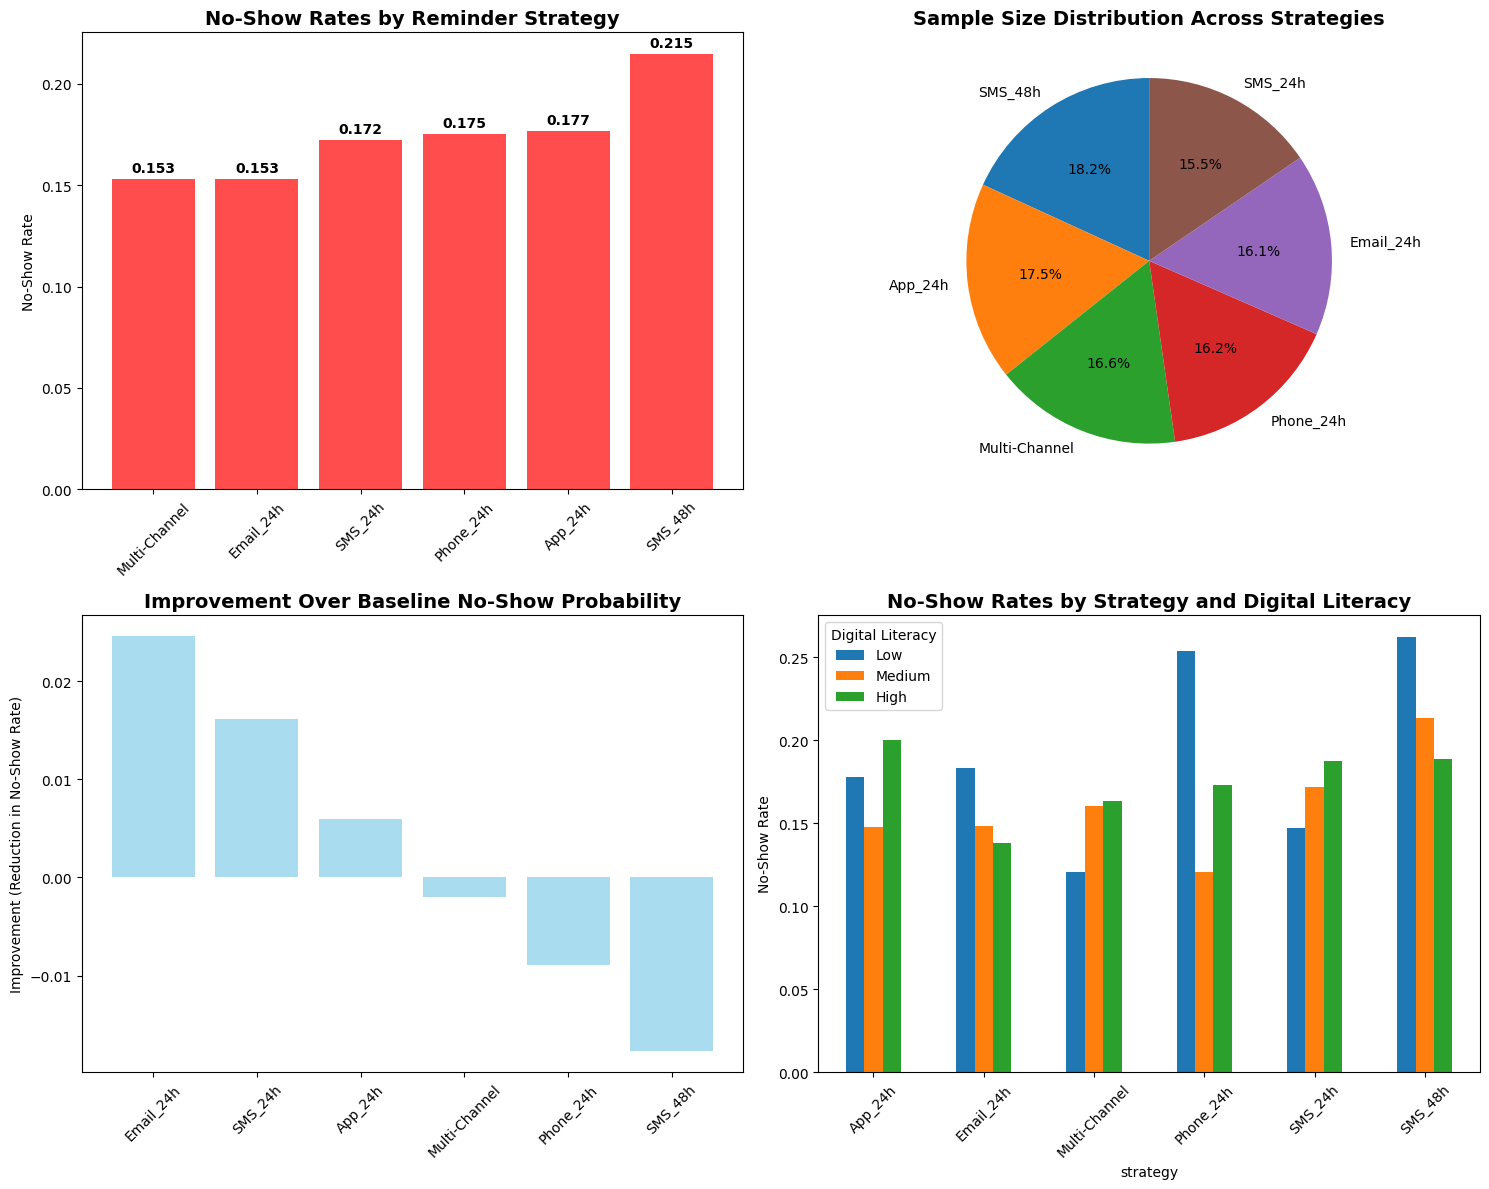

In [30]:
def visualise_ab_test_results(ab_test_df,results):
  """
  Create comprehensive visualization for A/B test result
  """
  fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Plot 1: No-show rates by strategy
  plt.subplot(2, 2, 1)
  strategy_rates = ab_test_df.groupby('strategy')['no_show'].mean().sort_values()
  colors = ['green' if rate < 0.1 else 'orange' if rate < 0.12 else 'red' for rate in strategy_rates]
  bars = plt.bar(strategy_rates.index, strategy_rates.values, color=colors, alpha=0.7)
  plt.title('No-Show Rates by Reminder Strategy', fontsize=14, fontweight='bold')
  plt.ylabel('No-Show Rate')
  plt.xticks(rotation=45)

    # Add value labels on bars
  for bar, rate in zip(bars, strategy_rates.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
                  f'{rate:.3f}', ha='center', va='bottom', fontweight='bold')

    # Plot 2: Sample sizes
  plt.subplot(2, 2, 2)
  sample_sizes = ab_test_df['strategy'].value_counts()
  plt.pie(sample_sizes.values, labels=sample_sizes.index, autopct='%1.1f%%', startangle=90)
  plt.title('Sample Size Distribution Across Strategies', fontsize=14, fontweight='bold')

    # Plot 3: Improvement over baseline
  plt.subplot(2, 2, 3)
  improvement = results['improvement'].sort_values(ascending=False)
  plt.bar(improvement.index, improvement.values, color='skyblue', alpha=0.7)
  plt.title('Improvement Over Baseline No-Show Probability', fontsize=14, fontweight='bold')
  plt.ylabel('Improvement (Reduction in No-Show Rate)')
  plt.xticks(rotation=45)

    # Plot 4: Strategy effectiveness by digital literacy
  plt.subplot(2, 2, 4)
  digital_literacy_effect = pd.crosstab(
  ab_test_df['strategy'],
  ab_test_df['digital_literacy'],
  values=ab_test_df['no_show'],
  aggfunc='mean'
      )
  digital_literacy_effect.plot(kind='bar', ax=plt.gca())
  plt.title('No-Show Rates by Strategy and Digital Literacy', fontsize=14, fontweight='bold')
  plt.ylabel('No-Show Rate')
  plt.legend(['Low', 'Medium', 'High'], title='Digital Literacy')
  plt.xticks(rotation=45)

  plt.tight_layout()
  plt.show()

# Create visualizations
visualise_ab_test_results(ab_test_df, results)

In [31]:
def cost_benefit_analysis(ab_test_df, results):
  """
  Analyze cost vs benefit of different strategies
  """
  print ("\n" +"=" * 60)
  print ("Cost-benefit analysis")
  print ("="*60)
  cost_per_appointment_value = 150
  strategy_costs_map = {'SMS_24h':0.10,'SMS_48h':0.15,'Email_24h':0.05,'Phone_24h':2.50,'App_24h':0.08,'Multi-Channel':0.35} # Corrected keys to match ab_test_df 'strategy' names
  cb_result = []
  for strategy in ab_test_df['strategy'].unique():
    strategy_data = ab_test_df[ab_test_df['strategy'] == strategy]
    n_appointments = len(strategy_data)
    no_show_rate = strategy_data['no_show'].mean()
    attendance_rate = 1 - no_show_rate # Corrected: defined attendance_rate

    #calculate financial impact
    lost_revenue = cost_per_appointment_value * no_show_rate * n_appointments
    current_strategy_cost = strategy_costs_map.get(strategy, 0)
    reminder_cost = n_appointments * current_strategy_cost
    net_revenue = (n_appointments * attendance_rate * cost_per_appointment_value) - reminder_cost
    cost_per_attended_calc = reminder_cost / (n_appointments * attendance_rate) if (n_appointments * attendance_rate) > 0 else np.nan

    cb_result.append({
        'strategy':strategy,
        'appointments':n_appointments,
        'no_show_rate':no_show_rate,
        'attendance_rate':attendance_rate,
        'lost_revenue':lost_revenue,
        'roi':(net_revenue - reminder_cost) / reminder_cost if reminder_cost > 0 else float('inf'),
        'reminder_cost':reminder_cost,
        'net_revenue':net_revenue,
        'cost_per_attended':cost_per_attended_calc
    })

  cb_df = pd.DataFrame(cb_result)
  cb_df = cb_df.sort_values('net_revenue',ascending = False) # Corrected false to False
  return cb_df

# Call the function and store its return value
cost_benefit_df = cost_benefit_analysis(ab_test_df,results)
# Print the returned DataFrame
print(cost_benefit_df.round(2))


Cost-benefit analysis
        strategy  appointments  no_show_rate  attendance_rate  lost_revenue  \
4        App_24h           526          0.18             0.82       13950.0   
3        SMS_48h           545          0.21             0.79       17550.0   
0  Multi-Channel           497          0.15             0.85       11400.0   
2      Email_24h           483          0.15             0.85       11100.0   
1      Phone_24h           485          0.18             0.82       12750.0   
5        SMS_24h           464          0.17             0.83       12000.0   

       roi  reminder_cost  net_revenue  cost_per_attended  
4  1541.49          42.08     64907.92               0.10  
3   783.32          81.75     64118.25               0.19  
0   361.04         173.95     62976.05               0.41  
2  2538.37          24.15     61325.85               0.06  
1    47.48        1212.50     58787.50               3.03  
5  1239.38          46.40     57553.60               0.12  


In [32]:
def generate_recommendations(ab_test_df, stats_results, cost_benefit_df):
    """
    Generate data-driven recommendations based on A/B test results
    """
    print("\n" + "=" * 60)
    print("DATA-DRIVEN RECOMMENDATIONS")
    print("=" * 60)

    # Find best performing strategies
    best_overall = cost_benefit_df.iloc[0]
    best_low_cost = cost_benefit_df[cost_benefit_df['cost_per_attended'] < 0.20].iloc[0]

    # Significant improvements
    significant_improvements = stats_results[stats_results['significant_chisq'] &
                                           (stats_results['difference'] < 0)]

    print(" TOP RECOMMENDATIONS:")
    print(f"1. BEST OVERALL STRATEGY: {best_overall['strategy']}")
    print(f"   • No-show rate: {best_overall['no_show_rate']:.3f}")
    print(f"   • Net revenue: ${best_overall['net_revenue']:,.2f}")
    print(f"   • Cost per attended appointment: ${best_overall['cost_per_attended']:.2f}")

    print(f"\n2. MOST COST-EFFECTIVE: {best_low_cost['strategy']}")
    print(f"   • Cost per attended: ${best_low_cost['cost_per_attended']:.2f}")
    print(f"   • Good balance of cost and effectiveness")

    if len(significant_improvements) > 0:
        print(f"\n3. STATISTICALLY SIGNIFICANT IMPROVEMENTS:")
        for _, strategy in significant_improvements.iterrows():
            print(f"   • {strategy['strategy']}: {strategy['difference']:.4f} reduction (p={strategy['p_value_chisq']:.4f})")

    # Segment-specific recommendations
    print(f"\n4. SEGMENT-SPECIFIC RECOMMENDATIONS:")

    # Digital literacy segments
    for dl_level, dl_name in [(0, 'Low'), (1, 'Medium'), (2, 'High')]:
        dl_data = ab_test_df[ab_test_df['digital_literacy'] == dl_level]
        best_dl_strategy = dl_data.groupby('strategy')['no_show'].mean().idxmin()
        best_dl_rate = dl_data.groupby('strategy')['no_show'].mean().min()
        print(f"   • {dl_name} Digital Literacy: {best_dl_strategy} (no-show: {best_dl_rate:.3f})")

    # Age-based recommendations
    age_segments = [
        (0, 30, 'Young (18-30)'),
        (31, 45, 'Middle (31-45)'),
        (46, 60, 'Older (46-60)'),
        (61, 100, 'Senior (60+)')
    ]

    for min_age, max_age, segment_name in age_segments:
        age_data = ab_test_df[(ab_test_df['age'] >= min_age) & (ab_test_df['age'] <= max_age)]
        if len(age_data) > 0:
            best_age_strategy = age_data.groupby('strategy')['no_show'].mean().idxmin()
            best_age_rate = age_data.groupby('strategy')['no_show'].mean().min()
            print(f"   • {segment_name}: {best_age_strategy} (no-show: {best_age_rate:.3f})")

# Generate final recommendations
generate_recommendations(ab_test_df, stats_result, cost_benefit_df)


DATA-DRIVEN RECOMMENDATIONS
 TOP RECOMMENDATIONS:
1. BEST OVERALL STRATEGY: App_24h
   • No-show rate: 0.177
   • Net revenue: $64,907.92
   • Cost per attended appointment: $0.10

2. MOST COST-EFFECTIVE: App_24h
   • Cost per attended: $0.10
   • Good balance of cost and effectiveness

4. SEGMENT-SPECIFIC RECOMMENDATIONS:
   • Low Digital Literacy: Multi-Channel (no-show: 0.120)
   • Medium Digital Literacy: Phone_24h (no-show: 0.121)
   • High Digital Literacy: Email_24h (no-show: 0.138)
   • Young (18-30): Email_24h (no-show: 0.150)
   • Middle (31-45): Multi-Channel (no-show: 0.116)
   • Older (46-60): Multi-Channel (no-show: 0.123)
   • Senior (60+): Email_24h (no-show: 0.153)


In [33]:
def create_implementation_plan(cost_benefit_df, rollout_percentage=0.3):
    """
    Create a phased implementation plan for the winning strategy
    """
    best_strategy = cost_benefit_df.iloc[0]['strategy']
    best_attendance_rate = 1 - cost_benefit_df.iloc[0]['no_show_rate']

    print(f"\n{'=' * 60}")
    print(f"IMPLEMENTATION PLAN: {best_strategy}")
    print(f"{'=' * 60}")

    # Calculate expected impact
    total_monthly_appointments = 5000  # Adjust based on your volume
    phased_appointments = total_monthly_appointments * rollout_percentage
    current_attendance_rate = 0.85  # Adjust based on your baseline
    expected_improvement = best_attendance_rate - current_attendance_rate

    additional_attended = phased_appointments * expected_improvement
    additional_revenue = additional_attended * 150  # $150 per appointment

    print(f"PHASED ROLLOUT ({rollout_percentage*100}% of appointments):")
    print(f"• Monthly appointments affected: {phased_appointments:,.0f}")
    print(f"• Expected additional attended appointments: {additional_attended:,.0f}")
    print(f"• Estimated additional monthly revenue: ${additional_revenue:,.2f}")
    print(f"• Implementation cost: ${phased_appointments * cost_benefit_df.iloc[0]['cost_per_attended']:,.2f}")
    print(f"• Net monthly benefit: ${additional_revenue - (phased_appointments * cost_benefit_df.iloc[0]['cost_per_attended']):,.2f}")

    print(f"\nNEXT STEPS:")
    print(f"1. Technical setup for {best_strategy} reminders")
    print(f"2. Staff training and process updates")
    print(f"3. Patient communication about new reminder system")
    print(f"4. Monitor results for 30 days")
    print(f"5. Full rollout if targets are met")

# Create implementation plan
create_implementation_plan(cost_benefit_df)


IMPLEMENTATION PLAN: App_24h
PHASED ROLLOUT (30.0% of appointments):
• Monthly appointments affected: 1,500
• Expected additional attended appointments: -40
• Estimated additional monthly revenue: $-6,031.37
• Implementation cost: $145.77
• Net monthly benefit: $-6,177.14

NEXT STEPS:
1. Technical setup for App_24h reminders
2. Staff training and process updates
3. Patient communication about new reminder system
4. Monitor results for 30 days
5. Full rollout if targets are met


In [34]:
!pip install fastapi uvicorn python-multipart pydantic pandas numpy scipy scikit-learn xgboost

In [35]:
#fastAPI app
app = FastAPI(title = "Appointment A/B testing API",version ="1.0.0")

In [36]:
# models
class DigitalLiteracy (str,Enum):
  Low ="low"
  medium = "medium"
  high = "high"

class PatienceRequests(BaseModel):
  age:int
  digital_literacy : DigitalLiteracy
  distance_from_clinic_km:float
  past_no_show_count: int = 0

@app.get("/")
def root():
  return {"message":"API is running!","status":"success"}

@app.post("/predict")
def predict(patient:PatienceRequests):
  base_prob = 0.15

  if patient.digital_literacy == DigitalLiteracy.low:
    base_prob += 0.05
  elif patient.digital_literacy == DigitalLiteracy.high:
    base_prob -= 0.03

  if patient.past_no_show_count > 0:
    base_prob += 0.08

  if patient.distance_from_clinic_km > 20:
    base_prob += 0.04

  return {"risk":round(base_prob,3),"recommendation":"SMS" if base_prob < 0.15 else "Phone",
          "confidence":0.85}
def start_server():
  uvicorn.run(app,host="0.0.0.0",port=8000)

print("Starting server...")
server_thread = threading.Thread(target=start_server,daemon = True)
server_thread.start()
time.sleep(3)
print("Server started at http://localhost:8000")
print("Docs: http://localhost:8000/docs")

INFO:     Started server process [498]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


Starting server...
Server started at http://localhost:8000
Docs: http://localhost:8000/docs


In [37]:
import requests
response = requests.get("http://localhost:8000/")
print(response.json())

INFO:     127.0.0.1:55522 - "GET / HTTP/1.1" 200 OK
{'message': 'API is running!', 'status': 'success'}
